The Spotify Sequential Skip Prediction Challenge used Averaged Accuracy (AA) to evaluate the model performance, which is conceptually a conditional accuracy of predictions in a sequence. 

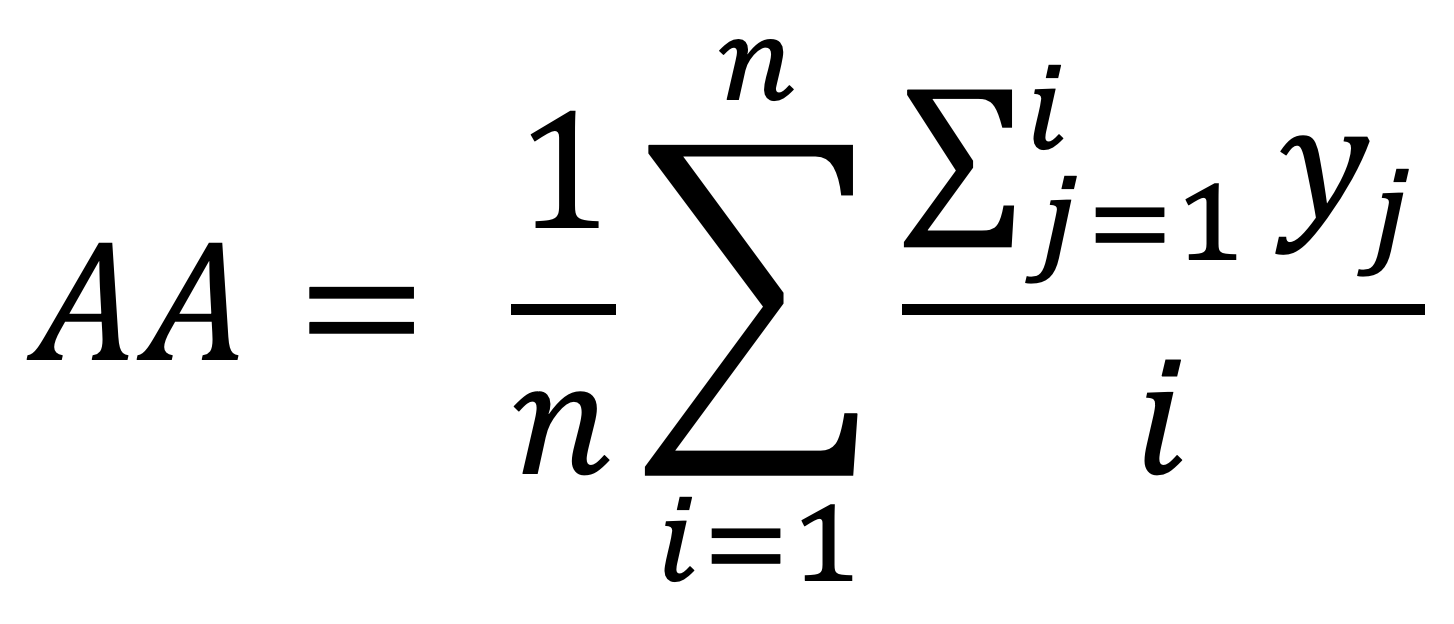

n is the length of the sequence, y_i is the boolean outcome of the prediction (1 for correct, 0 for wrong).

For instance, if the predictions of a sequence of 5 tracks are [1, 1, 1, 0, 1] , then the AA equals to (1/1 + 2/2 + 3/3 + 3/4 + 4/5)/5 = 0.910

For another instance: [0, 1, 1, 1, 1], the AA would be (0/1 + 1/2 + 2/3 + 3/4 + 4/5) = 0.543

Despite these two sequences have the same accuracy 0.8, their AA values are very different, as AA penalizes the error in the first track way more than the following tracks. Therefore, this factor needs to be considered while training the machine learning model. 

While it is possible to use this customized metrics for training the model, this iterative calculation is extremely slow. To avoid that inefficiency, I used this script to empirically estimate the weights of the tracks in a sequence as an approximation. These estimated weights can simply be incorporated to train any machine learning models.

https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge

In [18]:
import pandas as pd
import numpy as np


def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output.copy()
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

def precise_weight_perSession(df_test_pred):
    # calculate the average weight per session position (counted from the 1st track being predicted) * session length
    def new_weight(n):
            import itertools
            t = [1] * n
            p_list = list(itertools.product([0, 1], repeat=n))
            dd = pd.DataFrame(pd.Series(p_list).tolist())

            ap_list = []
            for p in p_list:
                ap_list.append(ave_pre(p,t,0))
            dd['ap'] = ap_list

            mean_diff = []
            for nn in range(n):
                mean_diff.append(dd.groupby(by = nn)['ap'].mean().diff()[1])
            
            return mean_diff

#             return mean_diff/mean_diff[0]
    
    # calculate the average weight per session position (counted from the 1st track being predicted), average over session length
    pp = pd.DataFrame([[np.nan] * 10 for i in range(6)])
    c = 0
    for n in range(5,11):
        pp.iloc[c,:n] = new_weight(n)
        c += 1

    ave_weight_list = pp.iloc[-1]
    
    a = df_test_pred['session_position'] - np.floor(df_test_pred['session_length']/2) - 1 # for example, the 6th track in a 10-track session, a will be 6-(10/2)-1 = 0
    if (a<0).sum()>0:
        raise Exception('***a number equal or below 0***')
        
    # as the final AA is calculated by averaging the ap per session, each track in the shorter session will have higher contribution to the final AA
    weight = [i / j for i, j in zip(ave_weight_list[a], np.floor(df_test_pred['session_length']/2))]
    return weight

In [15]:
log_df = pd.read_csv('../data/raw/training_set/log_0_20180715_000000000000.csv')
log_df = log_df.loc[log_df['session_position']>(log_df['session_length']/2)]

In [4]:
log_df

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
10,0_00006f66-33e5-4de7-a324-2d18e439fc1e,11,20,t_79570b2a-639a-4ec0-9853-71c5299ac44d,True,True,True,False,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
11,0_00006f66-33e5-4de7-a324-2d18e439fc1e,12,20,t_69016f19-84aa-40c0-afa9-54404397b7a2,True,True,True,False,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
12,0_00006f66-33e5-4de7-a324-2d18e439fc1e,13,20,t_59dc3fcd-7aec-4da5-a747-b59b19bab3bb,True,True,True,False,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
13,0_00006f66-33e5-4de7-a324-2d18e439fc1e,14,20,t_a157ba98-7eae-4e7d-99d5-ed760b2c0978,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,trackdone
14,0_00006f66-33e5-4de7-a324-2d18e439fc1e,15,20,t_87d95b75-af5c-4ef6-8dc4-cd888ae17cce,False,True,True,False,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,fwdbtn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990604,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,16,20,t_7cfd4fc9-6811-41a2-8bea-daed723afc69,True,True,True,False,0,1,...,0,0,0,True,5,2018-07-15,True,user_collection,fwdbtn,backbtn
2990605,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,17,20,t_5c99f04b-47c6-4307-bb21-75b068b5d078,True,True,True,False,0,1,...,0,0,0,True,5,2018-07-15,True,user_collection,backbtn,fwdbtn
2990606,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,18,20,t_7cfd4fc9-6811-41a2-8bea-daed723afc69,True,True,True,False,0,1,...,0,0,0,True,5,2018-07-15,True,user_collection,fwdbtn,backbtn
2990607,0_ffffc3a8-e6fd-49a0-9bf9-2b464c14f769,19,20,t_5c99f04b-47c6-4307-bb21-75b068b5d078,False,False,True,False,0,1,...,0,4,0,True,5,2018-07-15,True,user_collection,backbtn,fwdbtn


In [19]:
weight = precise_weight_perSession(log_df)

In [20]:
weight

[0.019644841269841264,
 0.01464484126984127,
 0.012144841269841267,
 0.010478174603174606,
 0.0092281746031746,
 0.008228174603174598,
 0.007394841269841268,
 0.006680555555555556,
 0.006055555555555559,
 0.0055,
 0.019644841269841264,
 0.01464484126984127,
 0.012144841269841267,
 0.010478174603174606,
 0.0092281746031746,
 0.008228174603174598,
 0.007394841269841268,
 0.006680555555555556,
 0.006055555555555559,
 0.0055,
 0.019644841269841264,
 0.01464484126984127,
 0.012144841269841267,
 0.010478174603174606,
 0.0092281746031746,
 0.008228174603174598,
 0.007394841269841268,
 0.006680555555555556,
 0.006055555555555559,
 0.0055,
 0.019644841269841264,
 0.01464484126984127,
 0.012144841269841267,
 0.010478174603174606,
 0.0092281746031746,
 0.008228174603174598,
 0.007394841269841268,
 0.006680555555555556,
 0.006055555555555559,
 0.0055,
 0.03928968253968253,
 0.02928968253968254,
 0.024289682539682535,
 0.02095634920634921,
 0.0184563492063492,
 0.016456349206349197,
 0.028064058956

In [8]:
[1, 1*0.75, 1*0.75**2]

[1, 0.75, 0.5625]

In [ ]:
def eval_func(n):
if x==y:
            s += 1.0
            t += s / c
        c += 1

In [11]:
def new_weight(n):
    import itertools
    t = [1] * n
    p_list = list(itertools.product([0, 1], repeat=n))
    dd = pd.DataFrame(pd.Series(p_list).tolist())

    ap_list = []
    for p in p_list:
        ap_list.append(ave_pre(p,t,0))
    dd['ap'] = ap_list

    mean_diff = []
    for nn in range(n):
        mean_diff.append(dd.groupby(by = nn)['ap'].mean().diff()[1])

#     return mean_diff/mean_diff[0]
    return mean_diff

In [12]:
new_weight(5)

[0.3283333333333333,
 0.22833333333333333,
 0.1783333333333333,
 0.14499999999999996,
 0.12000000000000005]

In [13]:
new_weight(10)

[0.19644841269841265,
 0.1464484126984127,
 0.12144841269841267,
 0.10478174603174606,
 0.09228174603174599,
 0.08228174603174598,
 0.07394841269841268,
 0.06680555555555556,
 0.060555555555555585,
 0.05499999999999999]

In [14]:
0.146/0.196

0.7448979591836734